# (sqrt) **Multiple Linear Regression** 

---

## 0. Importing dependencies

In [57]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [58]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [59]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Zimbabwe', 'Country_Jordan', 'Country_Armenia', 'Country_New Zealand', 'Country_Tanzania', 'Country_Sri Lanka', 'Country_Yemen', 'Country_Venezuela', 'Country_Peru', 'Country_Malta', 'Country_Philippines', 'Country_Saudi Arabia', 'Country_Andorra', 'Country_Azerbaijan', 'Country_Georgia', 'Country_Nomadic', 'Country_Costa Rica', 'Country_Viet Nam', 'Country_Paraguay', 'Country_Serbia', 'Country_Slovakia', 'Country_Uzbekistan', 'Country_Estonia', 'Country_Kosovo', 'Country_Croatia', 'Country_Bangladesh', 'Country_El Salvador', 'Country_Mongolia', 'Country_Lebanon', 'Country_Kenya', 'Country_United Arab Emirates', 'Country_Bosnia-Herz.', 'Country_Angola', 'Country_Latvia', 'Country_Botswana', 'Ethnicity_North American / Central American', 'Country_North Macedonia', 'Country_Cyprus'}
Columns in the test set that aren't in the train set: {'Country_Trinidad and Tobago', 'Country_Republic of Korea', "Country_CÃ´te d'Ivoire", 'Co

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [60]:
# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

baseline_train_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Argentina,Country_Australia,Country_Austria,Country_Belgium,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Chile,Country_China,Country_Colombia,Country_Czech Republic,Country_Denmark,Country_Dominican Republic,Country_Ecuador,Country_Egypt,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Hungary,Country_India,Country_Indonesia,Country_Iran,Country_Ireland,Country_Israel,Country_Italy,Country_Japan,Country_Kazakhstan,Country_Lithuania,Country_Luxembourg,Country_Malaysia,Country_Mexico,Country_Morocco,Country_Netherlands,Country_Nigeria,Country_Norway,Country_Pakistan,Country_Poland,Country_Portugal,Country_Romania,Country_Russian Federation,Country_Singapore,Country_Slovenia,Country_South Africa,Country_South Korea,Country_Spain,Country_Sweden,Country_Switzerland,Country_Taiwan,Country_Thailand,Country_Turkey,Country_UK & Northern Ireland,Country_USA,Country_Ukraine,Country_Uruguay,Academic researcher,Blockchain,Cloud infrastructure engineer,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,"Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices","Developer, front-end","Developer, full-stack","Developer, game or graphics","Developer, mobile",Educator,"Engineer, data","Engineer, site reliability",Engineering manager,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,6.6,40205.0
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5.8,52769.0
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7.6,72243.0
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,12.2,62820.0


In [61]:
X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = np.sqrt(baseline_train_df['Annual_salary'])
y_test = np.sqrt(baseline_test_df['Annual_salary'])

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(2258, 92)
(2258,)

(553, 92)
(553,)


---

### 2.2. Identifying the target

In [62]:
# X_train = train_df.drop('Annual_salary', axis=1)
# X_test = test_df.drop('Annual_salary', axis=1)
# y_train = np.sqrt(train_df['Annual_salary'])
# y_test = np.sqrt(test_df['Annual_salary'])
#y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importnce
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

In [64]:
model = LinearRegression()

kf = KFold(n_splits=4, shuffle=True, random_state=42)
parameters = {'normalize':[True,False], 'fit_intercept':[True,False]}

# Needed custom functions for sqrt or log transformation of the target variable

def custom_rmse(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    mse = mean_squared_error(y_true_original, y_pred_original)
    return np.sqrt(mse)

def custom_r2(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    return r2_score(y_true_original, y_pred_original)

custom_scorer = {'r2': make_scorer(custom_r2, greater_is_better=True),  
                 'rmse': make_scorer(custom_rmse, greater_is_better=False)}

clf = GridSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=custom_scorer, return_train_score=True)  
clf.fit(X_train_scaled, y_train)


best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Best parameters found: {'fit_intercept': False, 'normalize': True}


#### 3.1.1. CV results

Let's look at results per parameter combination

In [65]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.621263,-1.123735e+58,31293.799539,3.228939e+33
1,0.621465,-1.302243e+49,31285.306233,1.080513e+29
2,-0.724070,-1.880136e+49,59836.478932,1.051032e+29
3,-0.724070,-1.880136e+49,59836.478932,1.051032e+29


In [66]:
results_df = pd.DataFrame(columns=['train_r2', 'test_r2', 'train_rmse', 'test_rmse'])

num_splits = kf.get_n_splits()  

for i in range(num_splits):
    train_r2_key = f"split{i}_train_r2"
    test_r2_key = f"split{i}_test_r2"
    train_rmse_key = f"split{i}_train_rmse"
    test_rmse_key = f"split{i}_test_rmse"
    
    for j in range(len(df_cv_results)):
        fold_results = {
            'train_r2': df_cv_results.loc[j, train_r2_key],
            'test_r2': df_cv_results.loc[j, test_r2_key],
            'train_rmse': -df_cv_results.loc[j, train_rmse_key],  
            'test_rmse': -df_cv_results.loc[j, test_rmse_key]    
        }
        results_df = results_df.append(fold_results, ignore_index=True)

results_df.index += 1
results_df.index.name = 'Fold'
results_df

,train_r2,test_r2,train_rmse,test_rmse
Fold,,,,
1,0.627734,-41556734547523174964472494750746723403277152211378192252928.0,31292.004251,10092030269591553913595988732280832.0
2,0.628378,-3673160268027413073026648012226087438466546663424.0,31264.92187,94880677331820871442031968256.0
3,0.628387,-93542469048.459869,31264.526001,15141268184.983593
4,0.628387,-93542469048.459869,31264.526001,15141268184.983593
5,0.615479,0.615801,31087.227321,32830.398584
6,0.615479,0.615801,31087.227321,32830.398584
7,-2.099543,-2.058278,88261.369439,92626.747385
8,-2.099543,-2.058278,88261.369439,92626.747385
9,0.624701,0.583756,30873.57176,33692.863781


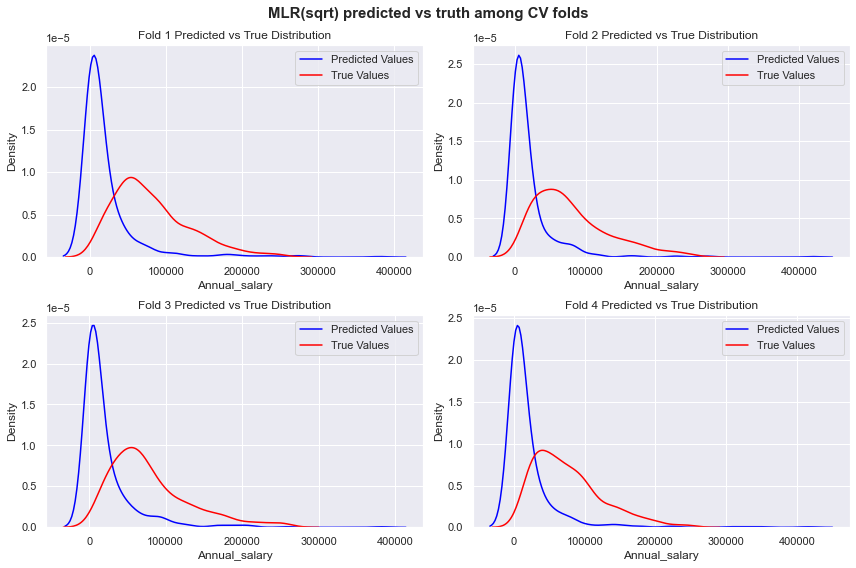

In [67]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    y_fold_pred = clf.predict(X_fold_test)

    plt.subplot(2, 2, fold_num)
    sns.kdeplot(np.power(y_fold_pred,2), color='blue', label='Predicted Values')
    sns.kdeplot(np.power(y_fold_true,2), color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1
    
plt.suptitle('MLR(sqrt) predicted vs truth among CV folds', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()


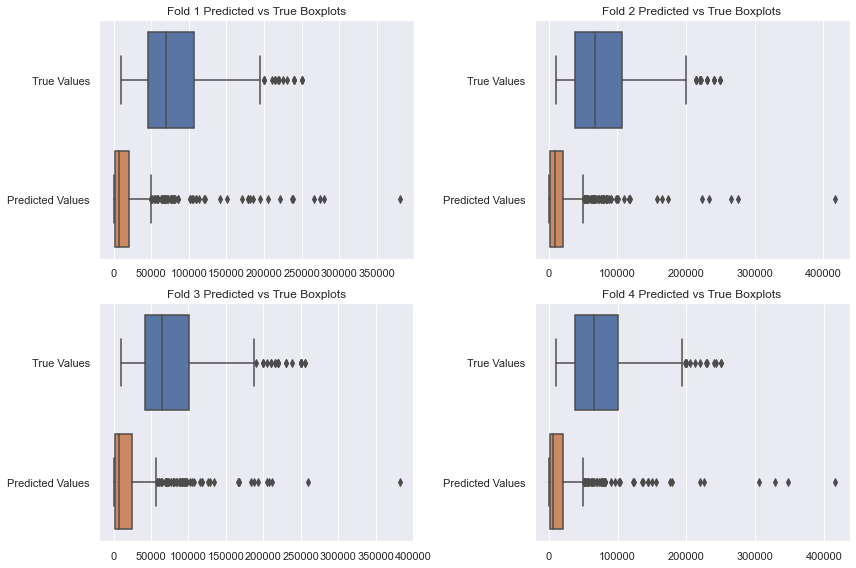

In [68]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    # Extrae los datos para este fold específico
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    # Realiza las predicciones para este fold
    y_fold_pred = clf.predict(X_fold_test)

    # Crear un subplot para cada fold
    plt.subplot(2, 2, fold_num)
    sns.boxplot(data=[np.power(y_fold_true,2), np.power(y_fold_pred,2)], orient='h')
    plt.yticks(ticks=[0, 1], labels=['True Values', 'Predicted Values'])
    plt.title(f'Fold {fold_num} Predicted vs True Boxplots')

    fold_num += 1

plt.tight_layout()
plt.show()

Now, the average of folds:

In [69]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  

print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Test R2: -2.8093381029758556e+57
Mean CV Test RMSE: 8.073142519099913e+32


### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [70]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y_true, inverse_transform=True):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    if inverse_transform:
        y_pred = np.power(y_pred, 2)  
        y_true = np.power(y_true, 2) 

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train set results


Train set metrics:
R^2: -1.9788213744751415
RMSE: 87778.57852323708
Adjusted R^2: -2.105404084152607


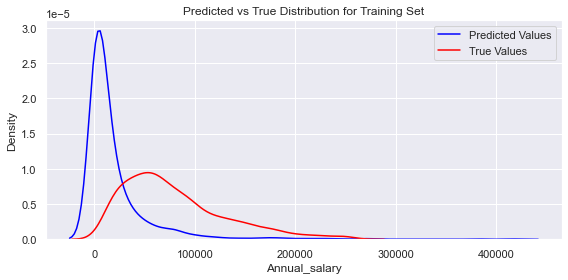

In [71]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train, inverse_transform=True)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")
    
y_train_pred = clf.best_estimator_.predict(X_train_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(np.power(y_train_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_train,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Training Set')
plt.legend()

plt.tight_layout()
plt.show()


Test set metrics:
R^2: -2.0577124491663437
RMSE: 86649.38931384534
Adjusted R^2: -2.6692549389996123


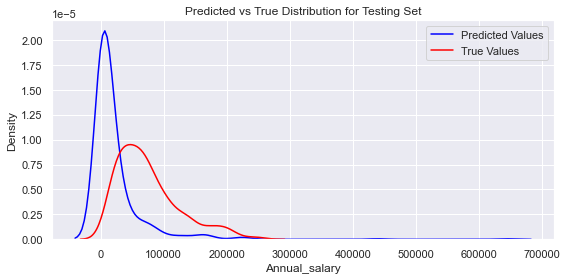

In [72]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test, inverse_transform=True)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")
    
y_test_pred = clf.best_estimator_.predict(X_test_scaled)

plt.figure(figsize=(8, 4))

# Plotting
sns.kdeplot(np.power(y_test_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_test,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

In [73]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

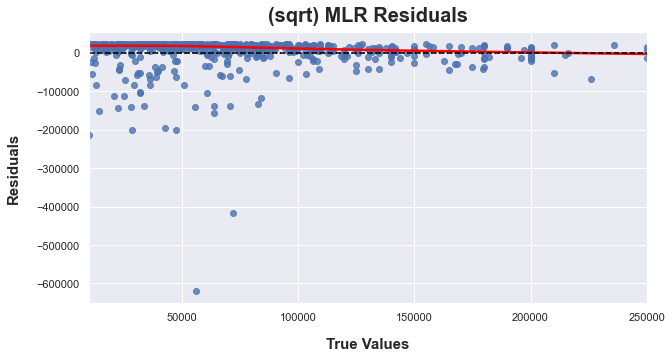

In [74]:
sns.set_theme(style='darkgrid')

residuals = np.power(y_test, 2) - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=np.power(y_test, 2), y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('(sqrt) MLR Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/sqrt-mlr-test-residuals.pdf");

In [75]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Ajustando un modelo OLS
X_with_const = sm.add_constant(X_train_scaled)  # Añadir una constante (intercepto) a las características
ols_model = sm.OLS(y_train, X_with_const).fit()

# Prueba de Breusch-Pagan
bp_test = het_breuschpagan(ols_model.resid, ols_model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("Breusch-Pagan Test:")
for value, label in zip(bp_test, labels):
    print(f"{label}: {value}")

Breusch-Pagan Test:
LM Statistic: 346.9312723054879
LM-Test p-value: 3.026166383103432e-31
F-Statistic: 4.320999369366158
F-Test p-value: 4.377712727850649e-35


### 4.2. Test set performance

<Figure size 720x432 with 0 Axes>

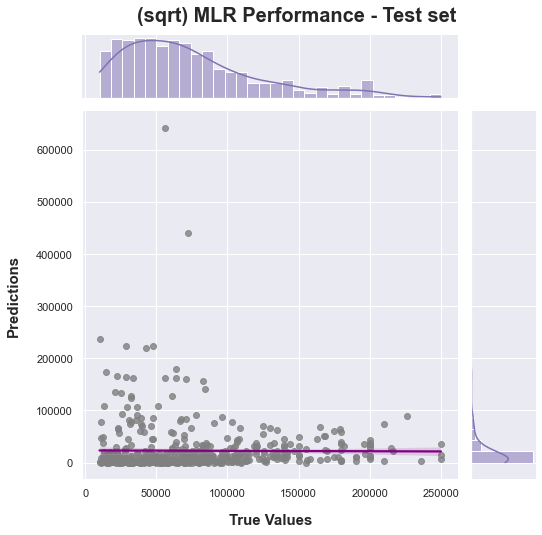

In [76]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=np.power(y_test, 2), y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('(sqrt) MLR Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt-mlr-test-predictions.pdf");

In [77]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Ajustando un modelo OLS
X_with_const = sm.add_constant(X_train_scaled)  # Añadir una constante (intercepto) a las características
ols_model = sm.OLS(y_train, X_with_const).fit()

# Prueba de Breusch-Pagan
bp_test = het_breuschpagan(ols_model.resid, ols_model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("Breusch-Pagan Test:")
for value, label in zip(bp_test, labels):
    print(f"{label}: {value}")

Breusch-Pagan Test:
LM Statistic: 346.9312723054879
LM-Test p-value: 3.026166383103432e-31
F-Statistic: 4.320999369366158
F-Test p-value: 4.377712727850649e-35


Heteroskedasticity may not be a major concern for prediction because it doesn't necessarily impair the accuracy or predictive power of the model. It primarily affects the efficiency of the coefficient estimates, potentially making standard errors incorrect. 

This inaccuracy can lead to incorrect inference on the coefficients (e.g., t-tests). So, if you're solely interested in predicting outcomes and not in interpreting the significance or magnitude of individual predictors, heteroskedasticity is less of an issue.

## 6. Saving results

Saving CV results

In [78]:
df_cv_results.to_csv("../../output/sqrt-mlr-cv-results.csv")

Saving train and test sets predictions

In [79]:
np.savetxt("../../output/sqrt-mlr-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/sqrt-mlr-test-predictions.csv", y_pred_test, delimiter=",")

In [80]:
pd.set_option('display.max_colwidth', None)

df_cv_results[['params', 'mean_train_r2', 'mean_test_r2']]

,params,mean_train_r2,mean_test_r2
0,"{'fit_intercept': True, 'normalize': True}",0.621263,-1.123735e+58
1,"{'fit_intercept': True, 'normalize': False}",0.621465,-1.302243e+49
2,"{'fit_intercept': False, 'normalize': True}",-0.724070,-1.880136e+49
3,"{'fit_intercept': False, 'normalize': False}",-0.724070,-1.880136e+49
